In [1]:
!pip install --upgrade pip
!pip install -q tensorflow-datasets
!pip install jaxlib --upgrade
!pip install --upgrade jax[cuda11_cudnn811] -f https://storage.googleapis.com/jax-releases/jax_releases.html
!pip install -q git+https://www.github.com/google/neural-tangents
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html
Defaulting to user installation because normal site-packages is not writeable


In [2]:
from jax import jit
from jax import grad
from jax import random

import numpy as np
import jax.numpy as jnp
from jax.example_libraries.stax import logsoftmax
from jax.example_libraries import optimizers

import tensorflow_datasets as tfds

import neural_tangents as nt
from neural_tangents import stax

In [3]:
def process_data(data_chunk):
    """Flatten the images and one-hot encode the labels."""
    image, label = data_chunk['image'], data_chunk['label']

    samples = image.shape[0]
    image = jnp.array(jnp.reshape(image, (samples, -1)), dtype=jnp.float32)
    image = (image - jnp.mean(image)) / jnp.std(image)
    label = jnp.eye(10)[label]

    return {'image': image, 'label': label}

In [4]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib
import seaborn as sns
import functools
sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})

import matplotlib.pyplot as plt

In [5]:
# set a subset of mnist data as train and test

dataset_size = 256

ds_train, ds_test = tfds.as_numpy(
    tfds.load('mnist:3.*.*', split=['train[:%d]' % dataset_size,
                                    'test[:%d]' % dataset_size],
              batch_size=-1)
)

train = process_data(ds_train)
test = process_data(ds_test)

In [6]:
learning_rate = 1e1
training_steps = jnp.arange(1000)
print_every = 100.0

In [7]:
# initialize network
init_fn, apply_fn, _ = stax.serial(
    stax.Dense(512, W_std=1.0, b_std=0.05), stax.Erf(),
    stax.Dense(512, W_std=1.0, b_std=0.05), stax.Erf(),
    stax.Dense(10, W_std=1.0, b_std=0.05)
)

key = random.PRNGKey(0)
_, params = init_fn(key, (-1, 784))

In [8]:
# initialize ntk
ntk = nt.batch(nt.empirical_ntk_fn(apply_fn, vmap_axes=0),
               batch_size=64, device_count=0)

g_dd = ntk(train['image'], None, params)
g_td = ntk(test['image'], train['image'], params)

In [9]:
loss = lambda fx, y_hat: 0.5 * jnp.mean((fx - y_hat) ** 2)
grad_loss = jit(grad(lambda params, x, y: loss(apply_fn(params, x), y)))

def loss_fn(predict_fn, ys, t, xs=None):
    # loss function
    mean, cov = predict_fn(t=t, get='ntk', x_test=xs, compute_cov=True)
    mean = jnp.reshape(mean, mean.shape[:1] + (-1,))
    var = jnp.diagonal(cov, axis1=1, axis2=2)
    ys = jnp.reshape(ys, (1, -1))

    mean_predictions = 0.5 * jnp.mean(ys ** 2 - 2 * mean * ys + var + mean ** 2,
                                   axis=1)

    return mean_predictions

legend = functools.partial(plt.legend, fontsize=10)

In [10]:
%matplotlib inline
def train_ntk_gd(learning_rate, training_step, X, Y, test_X, test_Y, params, apply_fn):
    """ train ntk and finite model gradient descent and plot """
    training_steps = jnp.arange(training_step)

    ntk = nt.batch(nt.empirical_ntk_fn(apply_fn, vmap_axes=0),
               batch_size=64, device_count=0)

    opt_init, opt_apply, get_params = optimizers.sgd(learning_rate)
    opt_state = opt_init(params)

    # train ntk
    k_train_train = ntk(X, None, params)
    k_test_train = ntk(test_X, X, params)
    predict_fn = nt.predict.gradient_descent_mse(k_train_train, Y,
                                            learning_rate=learning_rate)

    fx_train = apply_fn(params, X)
    fx_test = apply_fn(params, test_X)
    fx_train_t, fx_test_t = predict_fn(training_steps, fx_train, fx_test, k_test_train)

    ntk_train_loss = []
    ntk_test_loss = []
    
    train_losses = []
    test_losses = []
    
    # train finite model GD
    for i in training_steps:
        params = get_params(opt_state)
        opt_state = opt_apply(i, grad_loss(params, X, Y), opt_state)

        ntk_train_loss += [loss(fx_train_t[i], Y)]
        ntk_test_loss += [loss(fx_test_t[i], test_Y)]

        train_losses += [loss(apply_fn(params, X), Y)]
        test_losses += [loss(apply_fn(params, test_X), test_Y)]
        if i % 100 == 0:
            exact_loss = loss(apply_fn(params, X), Y)
            linear_loss = loss(fx_train_t[i], Y)
            print('{}\t{:.4f}\t{:.4f}'.format(i, exact_loss, linear_loss))

            
    plt.loglog(training_steps, ntk_train_loss, linewidth=3)
    plt.loglog(training_steps, ntk_test_loss, linewidth=3, linestyle = '--')
    
    plt.loglog(training_steps, train_losses, linewidth=2)
    plt.loglog(training_steps, test_losses, linewidth=2, linestyle = '--')
    


In [11]:
%matplotlib inline
def train_ntk(learning_rate, training_step, X, Y, test_X, test_Y, params, apply_fn):
    """ train ntkt and plot """

    training_steps = jnp.arange(training_step)

    ntk = nt.batch(nt.empirical_ntk_fn(apply_fn, vmap_axes=0),
               batch_size=64, device_count=0)

    # train_ntk
    k_train_train = ntk(X, None, params)
    k_test_train = ntk(test_X, X, params)
    predict_fn = nt.predict.gradient_descent_mse(k_train_train, Y,
                                            learning_rate=learning_rate)

    fx_train = apply_fn(params, X)
    fx_test = apply_fn(params, test_X)
    fx_train_t, fx_test_t = predict_fn(training_steps, fx_train, fx_test, k_test_train)

    ntk_train_loss = []
    ntk_test_loss = []
    
    train_losses = []
    test_losses = []
    
    for i in training_steps:
        ntk_train_loss += [loss(fx_train_t[i], Y)]
        ntk_test_loss += [loss(fx_test_t[i], test_Y)]

        if i % 100 == 0:
            linear_loss = loss(fx_train_t[i], Y)
            print('{}\t{:.4f}'.format(i, linear_loss))
            
    # plot
    plt.loglog(training_steps, ntk_train_loss, linewidth=3)
    plt.loglog(training_steps, ntk_test_loss, linewidth=3, linestyle = '--')

In [12]:
def shift_params(params, mean, std):
    """ shift normal distribution parameters to different """
    shifted_params = []
    for param in params:
        sp = []
        for i in range(len(param)):
            sp.append(param[i]*(std) + mean)
            
        shifted_params.append(sp)
    return shifted_params

def orthogonal_dense_params(rng, input_shape, out_dim, channel_axis=-1):
    """ generate dense params with orthogonal parameters """
    _channel_axis = channel_axis % len(input_shape)
    output_shape = (input_shape[:_channel_axis] + (out_dim,)
                    + input_shape[_channel_axis + 1:])
    rng1, rng2 = random.split(rng)
    W = random.normal(rng1, (input_shape[_channel_axis], out_dim))
    u , s, vh = jnp.linalg.svd(W, full_matrices=False)
    ortho_W = u @ vh
   
    b_shape = [1] * len(input_shape)
    b_shape[channel_axis] = out_dim
    b = random.normal(rng2, b_shape)
    ub , sb, vhb = jnp.linalg.svd(b, full_matrices=False)
    ortho_b = ub @ vhb

    return output_shape, (ortho_W, ortho_b)

def orthogonalize_params( params):
    """ generated orthogonalized parameters of same size as params"""
    ortho_params = []
    for param in params:
        ortho_param = []
        for p in param:
            u, s, vh = jnp.linalg.svd(p, full_matrices=False)
            ortho_param += [u @ vh]
        ortho_params += [ortho_param]
    return ortho_params

0	0.2250	0.2250
100	0.0404	0.0386
200	0.0255	0.0235
300	0.0186	0.0165
400	0.0145	0.0124
500	0.0117	0.0096
600	0.0096	0.0077
700	0.0081	0.0062
800	0.0069	0.0051
900	0.0059	0.0042


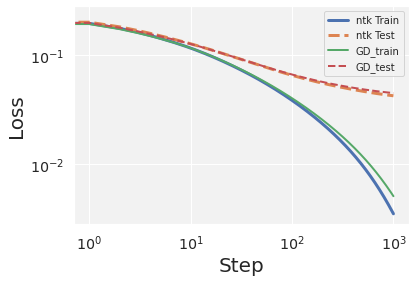

In [13]:
# standard ntk compared with gd
train_ntk_gd(learning_rate, 1000, train['image'], train['label'], test['image'], test['label'], params, apply_fn)
    # ax = plt.gca()
plt.xlabel('Step', fontsize=20)
plt.ylabel('Loss', fontsize=20)
legend(['ntk Train', 'ntk Test', 'GD_train', 'GD_test'])

0	0.2250
100	0.0386
200	0.0235
300	0.0165
400	0.0124
500	0.0096
600	0.0077
700	0.0062
800	0.0051
900	0.0042
0	255.7665
100	0.0439
200	0.0435
300	0.0433
400	0.0432
500	0.0431
600	0.0430
700	0.0430
800	0.0430
900	0.0430
0	0.0500
100	0.0479
200	0.0466
300	0.0458
400	0.0453
500	0.0450
600	0.0449
700	0.0447
800	0.0447
900	0.0446


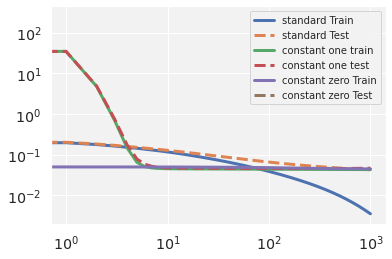

In [14]:
# constant initialization comparison with ntk
standard_params = shift_params(params, 0, 1)
train_ntk(learning_rate, 1000, train['image'], train['label'], test['image'], test['label'], standard_params, apply_fn)

constant_one_params = shift_params(params, 1, 0)
train_ntk(learning_rate, 1000, train['image'], train['label'], test['image'], test['label'], constant_one_params, apply_fn)

constant_zero_params = shift_params(params, 0, 0)
train_ntk(learning_rate, 1000, train['image'], train['label'], test['image'], test['label'], constant_zero_params, apply_fn)

legend(['standard Train', 'standard Test', 'constant one train', 'constant one test', 'constant zero Train', 'constant zero Test'])

0	0.2250
100	0.0386
200	0.0235
300	0.0165
400	0.0124
500	0.0096
600	0.0077
700	0.0062
800	0.0051
900	0.0042
0	2559154.7500
100	7.6650
200	4.6666
300	2.8477
400	1.7444
500	1.0752
600	0.6692
700	0.4230
800	0.2736
900	0.1830


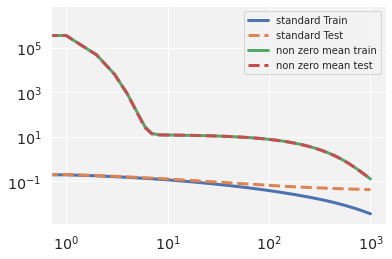

In [15]:
# mean experiment of normal distribution on ntk
standard_params = shift_params(params, 0, 1)
train_ntk(learning_rate, 1000, train['image'], train['label'], test['image'], test['label'], standard_params, apply_fn)

mean_one_params = shift_params(params, 100, 1)
train_ntk(learning_rate, 1000, train['image'], train['label'], test['image'], test['label'], mean_one_params, apply_fn)
legend(['standard Train', 'standard Test', 'non zero mean train', 'non zero mean test'])

0	0.2250
100	0.0386
200	0.0235
300	0.0165
400	0.0124
500	0.0096
600	0.0077
700	0.0062
800	0.0051
900	0.0042
0	556117.6250
100	71729.0547
200	39297.6914
300	24272.6914
400	16045.3721
500	11114.6162
600	7974.2456
700	5882.1060
800	4438.5366
900	3413.8708
0	0.0500
100	0.0479
200	0.0466
300	0.0458
400	0.0453
500	0.0450
600	0.0449
700	0.0447
800	0.0447
900	0.0446


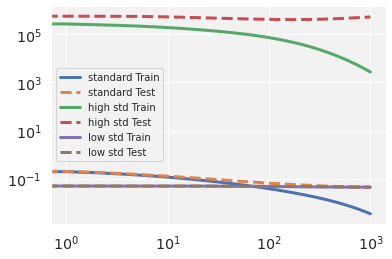

In [16]:
# variance experiment of normal distribution on ntk
standard_params = shift_params(params, 0, 1)
train_ntk(learning_rate, 1000, train['image'], train['label'], test['image'], test['label'], standard_params, apply_fn)

high_std_params = shift_params(params, 0, 1000)
train_ntk(learning_rate, 1000, train['image'], train['label'], test['image'], test['label'], high_std_params, apply_fn)

low_std_params = shift_params(params, 0, 0.001)
train_ntk(learning_rate, 1000, train['image'], train['label'], test['image'], test['label'], low_std_params, apply_fn)

legend(['standard Train', 'standard Test', 'high std Train', 'high std Test', 'low std Train', 'low std Test'])

0	0.2250
100	0.0386
200	0.0235
300	0.0165
400	0.0124
500	0.0096
600	0.0077
700	0.0062
800	0.0051
900	0.0042
0	0.0491
100	0.0473
200	0.0462
300	0.0456
400	0.0452
500	0.0449
600	0.0448
700	0.0447
800	0.0446
900	0.0446


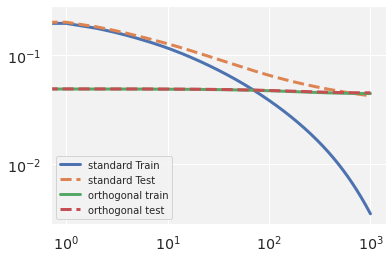

In [17]:
# orthogonal experiment on ntk

standard_params = shift_params(params, 0, 1)
train_ntk(learning_rate, 1000, train['image'], train['label'], test['image'], test['label'], standard_params, apply_fn)

ortho_params = orthogonalize_params(params)
train_ntk(learning_rate, 1000, train['image'], train['label'], test['image'], test['label'], ortho_params, apply_fn)
legend(['standard Train', 'standard Test', 'orthogonal train', 'orthogonal test'])

In [18]:
ortho_params = orthogonalize_params( params)

0	0.0491	0.0491
100	0.0473	0.0473
200	0.0462	0.0462
300	0.0456	0.0456
400	0.0452	0.0452
500	0.0449	0.0449
600	0.0448	0.0448
700	0.0447	0.0447
800	0.0446	0.0446
900	0.0446	0.0446


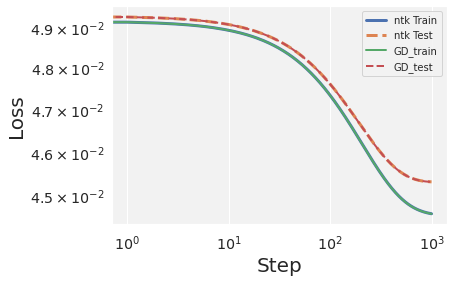

In [19]:
train_ntk_gd(learning_rate, 1000, train['image'], train['label'], test['image'], test['label'], ortho_params, apply_fn)
    # ax = plt.gca()
plt.xlabel('Step', fontsize=20)
plt.ylabel('Loss', fontsize=20)
legend(['ntk Train', 'ntk Test', 'GD_train', 'GD_test'])

In [20]:
# check orthogonality of ortho param bias and weights
print(ortho_params[0][1] @ ortho_params[0][1].T)
print(ortho_params[0][0].T @ ortho_params[0][0])

[[0.9999999]]


[[ 1.0000007e+00  1.6577542e-07 -8.7544322e-08 ... -7.4505806e-09
   5.1688403e-08  1.6950071e-07]
 [ 1.6577542e-07  9.9999851e-01 -7.4505806e-09 ...  9.3132257e-10
  -2.3836037e-07  3.7252903e-09]
 [-8.7544322e-08 -7.4505806e-09  9.9999988e-01 ...  1.8626451e-07
   2.0489097e-07  2.0861626e-07]
 ...
 [-7.4505806e-09  9.3132257e-10  1.8626451e-07 ...  1.0000000e+00
  -1.9464642e-07 -2.7101487e-07]
 [ 4.7031790e-08 -2.2375025e-07  2.0954758e-07 ... -2.0302832e-07
   9.9999958e-01 -9.3132257e-09]
 [ 1.6856939e-07  1.8626451e-08  2.0489097e-07 ... -2.5704503e-07
  -9.3132257e-09  9.9999976e-01]]
